In [116]:
import os

# To avoid memory leak issues with KMeans
os.environ["OMP_NUM_THREADS"] = "2"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules

from sqlalchemy import create_engine

In [119]:
# connection parameters
server = 'localhost'
database = 'BritishAirwaysDB'
driver = 'ODBC Driver 17 for SQL Server'

# Connection string
connection_string = f"mssql+pyodbc:///?odbc_connect={quote(f'DRIVER={{{driver}}};SERVER={server};DATABASE={database};Trusted_Connection=yes;')}"

try:
    # Establish a connection using pyodbc
    connection = pyodbc.connect(f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;')
    print("Connected successfully to the database.")

    # Execute a simple query to ensure everything is working
    cursor = connection.cursor()
    cursor.execute("SELECT @@version;")
    row = cursor.fetchone()
    if row:
        print("Database version:", row[0])

except pyodbc.Error as e:
    print("Error in connection:", e)

finally:
    # Close the connection when established
    if 'connection' in locals() and connection:
        connection.close()

# Create a SQLAlchemy engine
engine = create_engine(connection_string)

# Query the table
query = "SELECT * FROM MLData"
OpenFile = pd.read_sql(query, engine)


Connected successfully to the database.
Database version: Microsoft SQL Server 2022 (RTM) - 16.0.1000.6 (X64) 
	Oct  8 2022 05:58:25 
	Copyright (C) 2022 Microsoft Corporation
	Developer Edition (64-bit) on Windows 10 Home Single Language 10.0 <X64> (Build 26100: ) (Hypervisor)



In [122]:

# Show First ten
data = OpenFile
FirstTen = data.head(4)
FirstTen

,FlightID,Origin,Destination,Routes,DateFlown,TravellerType,SeatType,SeatComfort,CabinStaffService,FoodAndBeverages,InflightEntertainment,GroundService,ValueForMoney,RecommendedService,ReviewTitle,Review,RatingValue
0,334,Monrovia,Washington,Monrovia to Washington via Addas Ababa,2025-01-01,Couple Leisure,Economy Class,1.0,3.0,1.0,0.0,2.0,2.0,no,Not the best customer service,✅ Trip Verified | Not the best customer serv...,1.0
1,55,Addis Ababa,Toronto,Addis Ababa to Toronto via Rome,2025-01-01,Business,Business Class,2.0,1.0,1.0,1.0,2.0,3.0,no,Worst business class experience,✅ Trip Verified | Worst business class experie...,2.0
2,49,Addis Ababa,Nairobi,Addis Ababa to Nairobi,2024-12-01,Business,Economy Class,1.0,1.0,3.0,0.0,3.0,3.0,no,the toilets became dirty,✅ Trip Verified | Towards the end of the fli...,3.0
3,178,Dubai,Zanzibar,Dubai to Zanzibar via Ethiopia,2024-12-01,Couple Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,no,Worst service ever,✅ Trip Verified | Worst service ever. Beside d...,1.0


In [126]:
# Initialize OneHotEncoder

label_encoder = LabelEncoder()
data['RecommendedService'] = label_encoder.fit_transform(data['RecommendedService'])
data.head(10)


,FlightID,Origin,Destination,Routes,DateFlown,TravellerType,SeatType,SeatComfort,CabinStaffService,FoodAndBeverages,InflightEntertainment,GroundService,ValueForMoney,RecommendedService,ReviewTitle,Review,RatingValue
0,334,Monrovia,Washington,Monrovia to Washington via Addas Ababa,2025-01-01,Couple Leisure,Economy Class,1.0,3.0,1.0,0.0,2.0,2.0,0,Not the best customer service,✅ Trip Verified | Not the best customer serv...,1.0
1,55,Addis Ababa,Toronto,Addis Ababa to Toronto via Rome,2025-01-01,Business,Business Class,2.0,1.0,1.0,1.0,2.0,3.0,0,Worst business class experience,✅ Trip Verified | Worst business class experie...,2.0
2,49,Addis Ababa,Nairobi,Addis Ababa to Nairobi,2024-12-01,Business,Economy Class,1.0,1.0,3.0,0.0,3.0,3.0,0,the toilets became dirty,✅ Trip Verified | Towards the end of the fli...,3.0
3,178,Dubai,Zanzibar,Dubai to Zanzibar via Ethiopia,2024-12-01,Couple Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,0,Worst service ever,✅ Trip Verified | Worst service ever. Beside d...,1.0
4,205,Harar,Addis Ababa,Harar to Addis Ababa,2024-08-01,Solo Leisure,Economy Class,3.0,4.0,2.0,1.0,2.0,2.0,0,airline is NEVER on time,Not Verified | This airline is NEVER on time. ...,3.0
5,312,London,Nairobi,London to Nairobi via Addis Ababa,2024-07-01,Solo Leisure,Premium Economy,3.0,1.0,1.0,1.0,1.0,1.0,0,did not load my luggage,Not Verified | They did not load my luggage de...,2.0
6,424,Washington IAD,Johannesburg,Washington IAD to Johannesburg,2024-12-01,Couple Leisure,Economy Class,2.0,2.0,1.0,3.0,1.0,1.0,0,service fell painfully short,✅ Trip Verified | My recent journey from Was...,3.0
7,59,Addis Ababa,Washington,Addis Ababa to Washington via Lome,2024-11-01,Solo Leisure,Economy Class,2.0,2.0,1.0,1.0,2.0,1.0,0,Ethiopian Airlines needs to do better,✅ Trip Verified | I just landed from an Ethi...,1.0
8,129,Cape Town,Gatwick,Cape Town to Gatwick via Addis Ababa,2024-07-01,Solo Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,0,they won't respond,✅ Trip Verified | On their website they claim...,1.0
9,266,Lagos,Addis Ababa,Lagos to Addis Ababa,2024-03-01,Business,Economy Class,4.0,5.0,5.0,4.0,5.0,4.0,1,express my heartfelt appreciation,✅ Trip Verified | I would like to express my ...,9.0


In [129]:
# Select the relevant features for pattern identification

In [131]:
X = data[['SeatComfort', 'CabinStaffService', 'FoodAndBeverages', 'InflightEntertainment', 'GroundService', 'ValueForMoney']]

In [134]:
# Feature Engineering: to improve the quality of your data for clustering, pattern identification, and predictive modeling
# Normalize/Standardize our data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [137]:
# Clustering for Pattern Identification

In [77]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

C:\Users\osen1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [143]:
# Check DataFrame Columns
print(data.columns)

Index(['FlightID', 'Origin', 'Destination', 'Routes', 'DateFlown',
       'TravellerType', 'SeatType', 'SeatComfort', 'CabinStaffService',
       'FoodAndBeverages', 'InflightEntertainment', 'GroundService',
       'ValueForMoney', 'RecommendedService', 'ReviewTitle', 'Review',
       'RatingValue'],
      dtype='object')


In [80]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
data['DBSCAN_Cluster'] = dbscan.fit_predict(X)

In [83]:
# Hierarchical Clustering
agglo = AgglomerativeClustering(n_clusters=3)
data['Hierarchical_Cluster'] = agglo.fit_predict(X)

In [86]:
# Dimensionality Reduction

In [88]:
# PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]

In [91]:
# t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)
data['TSNE1'] = tsne_result[:, 0]
data['TSNE2'] = tsne_result[:, 1]

In [95]:
# Clustering Visualizations using PCA and t-SNE

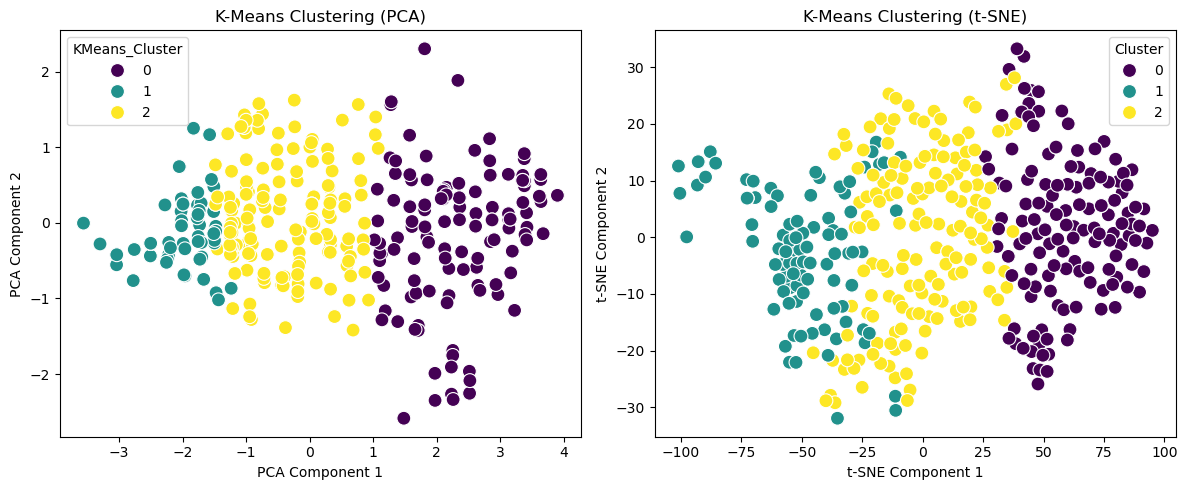

In [97]:
# K-Means Clustering Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='viridis', data=data, s=100)
plt.title('K-Means Clustering (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 2, 2)
sns.scatterplot(x='TSNE1', y='TSNE2', hue='KMeans_Cluster', palette='viridis', data=data, s=100)
plt.title('K-Means Clustering (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

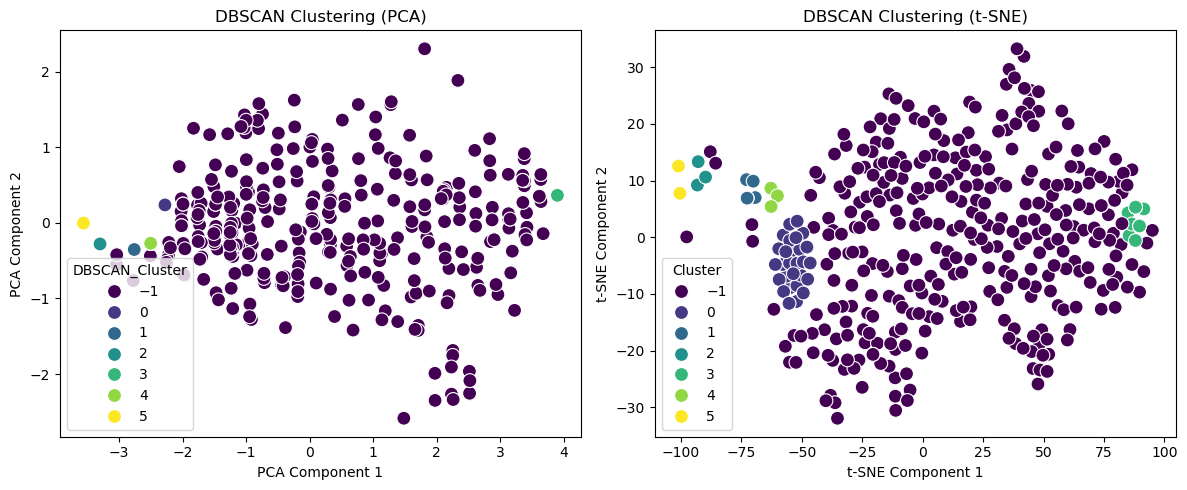

In [100]:
# DBSCAN Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='viridis', data=data, s=100)
plt.title('DBSCAN Clustering (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 2, 2)
sns.scatterplot(x='TSNE1', y='TSNE2', hue='DBSCAN_Cluster', palette='viridis', data=data, s=100)
plt.title('DBSCAN Clustering (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

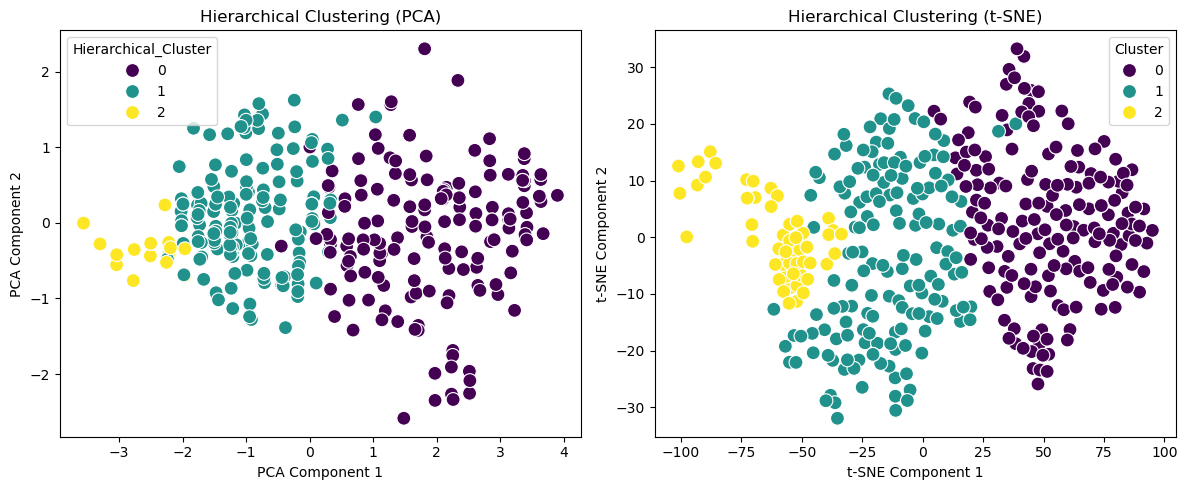

In [103]:
# Hierarchical Clustering Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='PCA1', y='PCA2', hue='Hierarchical_Cluster', palette='viridis', data=data, s=100)
plt.title('Hierarchical Clustering (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 2, 2)
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Hierarchical_Cluster', palette='viridis', data=data, s=100)
plt.title('Hierarchical Clustering (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [107]:
# Association Rule Mining

C:\Users\osen1\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


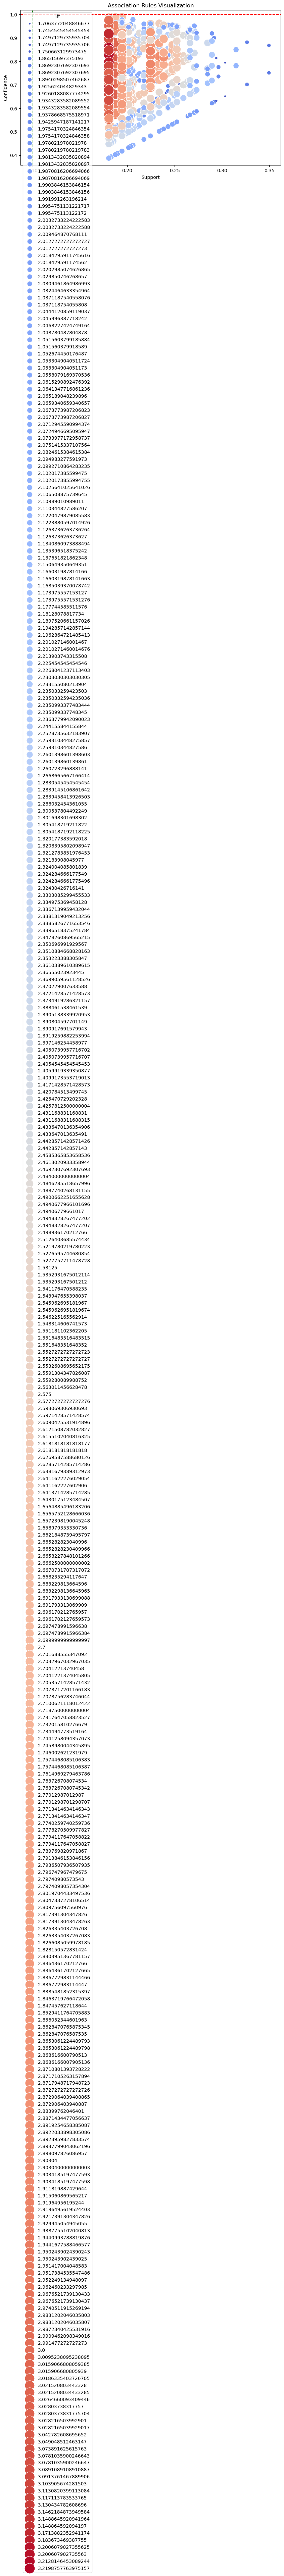

In [109]:
X_binary = (X > X.median()).astype(int)
frequent_itemsets = apriori(X_binary, min_support=0.1, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Visualization of Association Rules
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', size='lift', sizes=(20, 500), hue='lift', data=rules, palette='coolwarm', legend='full')
plt.title('Association Rules Visualization')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.axhline(y=1, color='r', linestyle='--')  # line for confidence
plt.axvline(x=0.1, color='g', linestyle='--')  # line for support
plt.show()

In [112]:
# Anomaly Detection

In [114]:
iso_forest = IsolationForest(contamination=0.1, random_state=42)
data['IsolationForest_Anomaly'] = iso_forest.fit_predict(X_scaled)

# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
data['LOF_Anomaly'] = lof.fit_predict(X_scaled)

# Step 9: Save Results to SQL
# data.to_sql('PatternIdentificationResults', engine, if_exists='replace', index=False)